**Import library dan pembacaan data**

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

dataFrame = pd.read_excel("bengkel.xlsx")
dataFrame.head(10)

,id,servis,harga
0,1,58,7
1,2,54,1
2,3,98,2
3,4,52,4
4,5,11,4
5,6,59,10
6,7,61,8
7,8,30,10
8,9,45,1
9,10,36,9


**Proses Fuzzifikasi**

In [57]:
# fungsi linguistik
def fuzzyLinguistik(x, point):
    # jika point berada didepan dan dibelakang grafik
    if x < point[0] or x > point[3]:
        return 0
    
    # jika point berada ditengah grafik
    elif x >= point[1] and x <= point[2]:
        return 1
    
    # jika point berada di 1/4 grafik kiri
    elif x >= point[0] and x < point[1]:
        return (x - point[0]) / (point[1] - point[0])
    
    # jika point berada di 1/4 grafik kanan
    elif x >= point[2] and x < point[3]:
        return (point[3] - x) / (point[3] - point[2])

    return 0

# fungsi membership
def fuzzyMembership(x, keanggotaan):
    result = {}

    # Mencari nilai fuzzy untuk masing-masing linguistik dalam Membership
    for ling in keanggotaan:
        result[ling] = fuzzyLinguistik(x, keanggotaan[ling])
        print(result)
    return result

# proses fuzzifikasi
def fuzzyfication(x, list_keanggotaan):

    fuzzyfication = []
    
    # menghitung nilai fuzzy dari member yang dibuat
    for i in range(len(list_keanggotaan)):
        fuzzyfication.append(fuzzyMembership(x[i], list_keanggotaan[i]))

    return fuzzyfication

**Plot Data Graph**

In [58]:
def plotLinguistik(point, warna, label='', min=0, max=1):
    # set nilai y 
    y = [0, 1, 1, 0]

    # plot garis pertama
    plt.plot([min, point[0]], [0, 0], warna)
    
    # plot garis antara garis pertama dan terakhir
    for i in range(len(point) - 1):
        plt.plot([point[i], point[i + 1]], [y[i], y[i + 1]], warna)
    
    # plot garis terakhir
    plt.plot([point[3], max], [0, 0], warna, label=label)

def linguistikGraph(membership, min=0, max=1):
    colors = ['b', 'g', 'r', 'y']

    # Plot masing-masing linguistik
    i = 0
    for ling in membership:
        plotLinguistik(membership[ling], colors[i], ling, min=min, max=max)
        i += 1
    
    plt.legend(loc=4)
    plt.show()

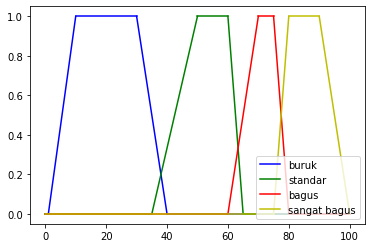

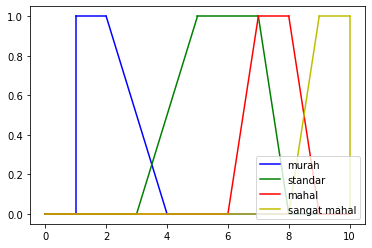

In [59]:
# Linguistik value harga
harga = {
    'murah'   : [1, 1, 2, 4],
    'standar' : [3, 5, 7, 8],
    'mahal'   : [6, 7, 8, 9],
    'sangat mahal' : [8, 9 , 10 , 10]
}

# Linguistik value pelayanan
pelayanan = {
    'buruk'   : [ 1, 10, 30, 40],
    'standar' : [ 35, 50, 60, 65],
    'bagus'   : [60, 70, 75, 80],
    'sangat bagus'  : [75, 80, 90, 100]
}

linguistikGraph(pelayanan, max=100)
linguistikGraph(harga, max=10)

**Proses Inferensi**

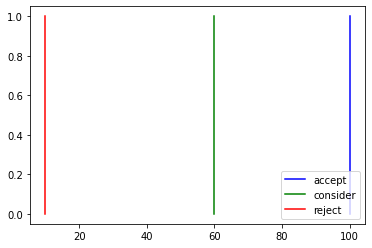

In [60]:
# aturan inferensi (pelayanan, harga)
rule = {
    ('buruk' , 'murah')   : 'reject',
    ('buruk' , 'mahal')  : 'reject',
    ('buruk' , 'standar') : 'reject',
    ('buruk' , 'sangat mahal')  : 'reject',
    ('standar' , 'murah')  : 'accept',
    ('standar' , 'standar')   : 'consider',
    ('standar' , 'mahal')  : 'reject',
    ('standar' , 'sangat mahal')  : 'reject',
    ('bagus' , 'murah')    : 'accept',
    ('bagus' , 'standar')  : 'accept',
    ('bagus' , 'mahal')  : 'consider',
    ('bagus' , 'sangat mahal')  : 'consider',
    ('sangat bagus' , 'standar')    : 'accept',
    ('sangat bagus' , 'murah')    : 'accept',
    ('sangat bagus' , 'mahal')  : 'accept',
    ('sangat bagus' , 'sangat mahal')  : 'consider',
}

# Membership Sugeno
accept_sugeno = {'accept':100, 'consider':60, 'reject':10}

# Plot Membership Sugeno
colors = 'bgry'
for key, val in accept_sugeno.items():
    plt.plot([val, val], [0, 1], colors[0], label=key )
    colors = colors[1:]
plt.legend(loc=4)

plt.show()

def inferensi(nilai_fuzzy, rule):  
    inferenceData = {}
    # loop nilai linguistik untuk membuat inference
    for l1, v1 in nilai_fuzzy[0].items():
        for l2, v2 in nilai_fuzzy[1].items():

            r, min_value = (l1, l2), min(v1, v2)
            
            # lihat nilai yang sudah didapat pada hasil
            current_value = inferenceData.get(rule[r], 0)
            
            # replace nilai hasil apabila current value lebih kecil
            inferenceData[rule[r]] = max(min_value, current_value)

    return inferenceData

**Proses Defuzzifikasi**

In [61]:
def sugenoDeffuzyfication(x_infer, membership):
    num, den = 0, 0

    # rumus defuzzification model sugeno
    for ling in membership:
        num += x_infer[ling] * membership[ling]
        den += x_infer[ling]
  
    if den > 0 :
      return num / den

# fuzzyfication
inference = []
skor = []

for x in dataFrame.drop('id', axis=1).values:
    x_fuzzy = fuzzyfication(x, [pelayanan, harga])
    x_infer = inferensi(x_fuzzy, rule)

    # penghitungan skor
    x_defuz = sugenoDeffuzyfication(x_infer, accept_sugeno)
    
    skor.append(x_defuz)
    inference.append(x_infer)

# membuat data frame untuk skor dan inference
dataFrame['Skor'] = skor
print(inference)
dataFrame['Infer'] = inference

# Mencari 10 restoran terbaik
dataFrame_top_ten = dataFrame.sort_values(by='Skor', ascending=False)[:10]
dataFrame_other = dataFrame.drop(dataFrame_top_ten.index)


{'buruk': 0}
{'buruk': 0, 'standar': 1}
{'buruk': 0, 'standar': 1, 'bagus': 0}
{'buruk': 0, 'standar': 1, 'bagus': 0, 'sangat bagus': 0}
{'murah': 0}
{'murah': 0, 'standar': 1}
{'murah': 0, 'standar': 1, 'mahal': 1}
{'murah': 0, 'standar': 1, 'mahal': 1, 'sangat mahal': 0}
{'buruk': 0}
{'buruk': 0, 'standar': 1}
{'buruk': 0, 'standar': 1, 'bagus': 0}
{'buruk': 0, 'standar': 1, 'bagus': 0, 'sangat bagus': 0}
{'murah': 1}
{'murah': 1, 'standar': 0}
{'murah': 1, 'standar': 0, 'mahal': 0}
{'murah': 1, 'standar': 0, 'mahal': 0, 'sangat mahal': 0}
{'buruk': 0}
{'buruk': 0, 'standar': 0}
{'buruk': 0, 'standar': 0, 'bagus': 0}
{'buruk': 0, 'standar': 0, 'bagus': 0, 'sangat bagus': 0.2}
{'murah': 1}
{'murah': 1, 'standar': 0}
{'murah': 1, 'standar': 0, 'mahal': 0}
{'murah': 1, 'standar': 0, 'mahal': 0, 'sangat mahal': 0}
{'buruk': 0}
{'buruk': 0, 'standar': 1}
{'buruk': 0, 'standar': 1, 'bagus': 0}
{'buruk': 0, 'standar': 1, 'bagus': 0, 'sangat bagus': 0}
{'murah': 0}
{'murah': 0, 'standar': 0.

**Hasil Perhitungan Fuzzy Logic**

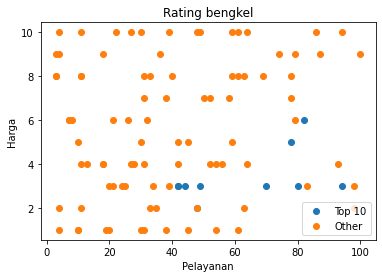

In [62]:
# Plot bengktel 10 terbaik
plt.scatter(dataFrame_top_ten.servis,
            dataFrame_top_ten.harga,
            label='Top 10')
plt.scatter(dataFrame_other.servis,
            dataFrame_other.harga,
            label='Other')

plt.xlabel('Pelayanan')
plt.ylabel('Harga')
plt.title('Rating bengkel')
plt.legend(loc='lower right')

plt.show()


In [63]:
# Menampilkan 10 data bengkel terbaik
dataFrame_top_ten

,id,servis,harga,Skor,Infer
55,56,49,3,100.0,"{'reject': 0, 'accept': 0.5, 'consider': 0}"
20,21,48,2,100.0,"{'reject': 0, 'accept': 0.8666666666666667, 'c..."
18,19,42,3,100.0,"{'reject': 0, 'accept': 0.4666666666666667, 'c..."
27,28,44,3,100.0,"{'reject': 0, 'accept': 0.5, 'consider': 0}"
16,17,70,3,100.0,"{'reject': 0, 'accept': 0.5, 'consider': 0}"
15,16,82,6,100.0,"{'reject': 0, 'accept': 1, 'consider': 0}"
14,15,78,5,100.0,"{'reject': 0, 'accept': 0.6, 'consider': 0}"
31,32,42,3,100.0,"{'reject': 0, 'accept': 0.4666666666666667, 'c..."
12,13,80,3,100.0,"{'reject': 0, 'accept': 0.5, 'consider': 0}"
51,52,94,3,100.0,"{'reject': 0, 'accept': 0.5, 'consider': 0}"


**Export data hasil perhitungan**

In [64]:
dataFrame_top_ten.to_csv("Top 10 Bengkel.csv")
dataFrame_top_ten.to_excel('peringkat 10 bengkel.xls', index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  
